In [1]:
import pandas as pd
import numpy as np
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# Load data

In [2]:
tag = pd.read_csv('./data/tag_cleaned.csv',index_col=0)
tag_map = dict(zip(tag.TAG,tag.chinese))
print(tag.shape)
tag

(95, 10)


,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,140,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,30,90,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****
...,...,...,...,...,...,...,...,...,...,...
90,91.0,MLPAP_TRC-0747.PV,E220出口溫度,溫度,℃,可控制因子,1分鐘2筆,100,200,***
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,第二模型使用,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,92.0,MLPAP_V225-PHD,粗PA儲槽PHD,組成,%,不可控制因子,1天1筆,0,0.1,***


In [3]:
df = pd.read_csv('./data/train_cleaned.csv',index_col=0,parse_dates=True)
print(df.shape)
df.head()

(193824, 93)


,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V225-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV
2016-05-09 00:00:00,400.0,401.95712,400.75186,402.25080,401.14877,401.0,400.05008,403.0,402.0,401.0,...,0.0,0.000005,4.045683,6.484770,NaN,-1.000000,1.635186,0.009,-1.382719,133.1
2016-05-09 00:10:00,400.0,401.94272,400.94990,402.24915,401.00000,401.0,400.24980,403.0,402.0,401.0,...,0.0,0.000010,4.152250,6.449888,NaN,-1.000000,1.625011,0.009,-1.382729,133.1
2016-05-09 00:20:00,400.0,401.90015,400.89978,402.10126,401.00000,401.0,400.10016,403.0,402.0,401.0,...,0.0,0.000014,4.202449,6.440503,NaN,-0.898558,1.649780,0.009,-1.400000,133.1
2016-05-09 00:30:00,400.0,401.94992,400.90020,402.30032,401.00000,401.0,400.14468,403.0,402.0,401.0,...,0.0,0.000019,4.146723,6.463649,NaN,-0.509010,1.635187,0.009,-1.400000,133.2
2016-05-09 00:40:00,400.0,402.00000,400.85004,402.17606,401.00000,401.0,400.40500,403.0,402.0,401.0,...,0.0,0.000024,4.011298,6.414799,NaN,-0.992771,1.654259,0.009,-1.300000,133.1


In [4]:
df.describe()[['MLPAP_FQ-0619.PV']]

,MLPAP_FQ-0619.PV
count,192392.000000
mean,5510.021150
std,3168.953844
min,0.000000
25%,3633.000000
50%,7286.370600
75%,7662.875250
max,7946.120600


In [5]:
feed_lb = df['MLPAP_FQ-0619.PV'].quantile(0.05)
feed_ub = df['MLPAP_FQ-0619.PV'].quantile(0.95)
feed_lb,feed_ub

(0.0, 7745.68685)

# check common columns

In [6]:
set(df.columns)^set(tag.TAG)

{nan, '第二模型使用'}

# spec clip or to np.nan

In [7]:
for i in tqdm(df.columns):
    if i == 'DATA OF USE':
        continue
    print(i)
    
    lb = float(tag[tag['TAG']==i]['min'].values[0])
    ub = float(tag[tag['TAG']==i]['max'].values[0])
    out = (df[i]<lb)|(df[i]>ub)
    
    '''
    超過spec的要 做clip 或著轉成 np.nan
    '''
    #df[i] = np.clip(df[i].values,lb,ub)
    df.loc[out,i] = np.nan

df.head()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


MLPAP_TJ-0706B02
MLPAP_TJ-0706B03
MLPAP_TJ-0706B04
MLPAP_TJ-0706B05
MLPAP_TJ-0706B06
MLPAP_TJ-0706B07
MLPAP_TJ-0706B08
MLPAP_TJ-0706B09
MLPAP_TJ-0706B10
MLPAP_TJ-0706B11
MLPAP_TJ-0706B12
MLPAP_TJ-0706B13
MLPAP_TJ-0706B14
MLPAP_TJ-0706B15
MLPAP_TJ-0706B16
MLPAP_TJ-0706B17
MLPAP_TJ-0706B18
MLPAP_TJ-0706B19
MLPAP_TJ-0706B20
MLPAP_TJ-0706B21
MLPAP_TJ-0706B22
MLPAP_TJ-0706B23
MLPAP_TJ-0706B24
MLPAP_TJ-0716A02
MLPAP_TJ-0716A03
MLPAP_TJ-0716A04
MLPAP_TJ-0716A05
MLPAP_TJ-0716A06
MLPAP_TJ-0716A07
MLPAP_TJ-0716A08
MLPAP_TJ-0716A09
MLPAP_TJ-0716A10
MLPAP_TJ-0716A11
MLPAP_TJ-0716A12
MLPAP_TJ-0716A13
MLPAP_TJ-0716A14
MLPAP_TJ-0716A15
MLPAP_TJ-0716A16
MLPAP_TJ-0716A17
MLPAP_TJ-0716A18
MLPAP_TJ-0716A19
MLPAP_TJ-0716A20
MLPAP_TJ-0716A21
MLPAP_TJ-0716A22
MLPAP_TJ-0716A23
MLPAP_TJR-0715A1.PV
MLPAP_TJR-0715A2.PV
MLPAP_TJR-0715B1.PV
MLPAP_TJR-0715B2.PV
MLPAP_TJR-0720A1.PV
MLPAP_TJR-0720A2.PV
MLPAP_TJR-0720B1.PV
MLPAP_TJR-0720B2.PV
MLPAP_TJR-0762A1.PV
MLPAP_TJR-0762A2.PV
MLPAP_TJR-0762B1.PV
MLPAP_TJR-0762B

,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V225-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV
2016-05-09 00:00:00,400.0,401.95712,400.75186,402.25080,401.14877,401.0,400.05008,403.0,402.0,401.0,...,NaN,0.000005,4.045683,NaN,NaN,NaN,1.635186,0.009,NaN,133.1
2016-05-09 00:10:00,400.0,401.94272,400.94990,402.24915,401.00000,401.0,400.24980,403.0,402.0,401.0,...,NaN,0.000010,4.152250,NaN,NaN,NaN,1.625011,0.009,NaN,133.1
2016-05-09 00:20:00,400.0,401.90015,400.89978,402.10126,401.00000,401.0,400.10016,403.0,402.0,401.0,...,NaN,0.000014,4.202449,NaN,NaN,NaN,1.649780,0.009,NaN,133.1
2016-05-09 00:30:00,400.0,401.94992,400.90020,402.30032,401.00000,401.0,400.14468,403.0,402.0,401.0,...,NaN,0.000019,4.146723,NaN,NaN,NaN,1.635187,0.009,NaN,133.2
2016-05-09 00:40:00,400.0,402.00000,400.85004,402.17606,401.00000,401.0,400.40500,403.0,402.0,401.0,...,NaN,0.000024,4.011298,NaN,NaN,NaN,1.654259,0.009,NaN,133.1


# not in 2000~7000 convert to np.nan

In [8]:
out = (df['MLPAP_FQ-0619.PV']<feed_lb)|(df['MLPAP_FQ-0619.PV']>feed_ub)
df.loc[out,'MLPAP_FQ-0619.PV'] = np.nan

# define columns

In [9]:
control_factor = tag[tag['category']=='可控制因子']['TAG'].values.tolist()
INPUT = get_col(df,'0619')
OUTPUT = get_col(df,'0997')
control_factor = list(set(control_factor) - set(INPUT) - set(OUTPUT) - set(['MLPAP_TJC-0757.PV']))
control_factor = sorted(control_factor)
for i in control_factor:
    print(i,tag_map[i])

MLPAP_FR-0632.PV 汽機風量
MLPAP_LIC-0738.PV 汽鼓(V211)鍋爐水液位
MLPAP_LRC-0729.PV 鍋爐水液位控制
MLPAP_PIC-0741.PV 汽鼓(V211)鍋爐水壓力
MLPAP_PIC-0761.PV 鹽浴冷卻器(E112)出口壓力
MLPAP_TJ-0757B.PV 反應槽鹽浴溫度
MLPAP_TJC-0627.PV OX預熱器出口溫度
MLPAP_TJC-0757A.PV 反應槽鹽浴溫度
MLPAP_TJC-1721.PV 轉換式冷凝器冷油溫度
MLPAP_TRC-0610.PV 空氣預熱器出口溫度
MLPAP_TRC-0747.PV E220出口溫度
MLPAP_TRC-0762.PV 鹽浴冷卻器(E112)入口溫度
MLPAP_TRC-1734.PV 轉換式冷凝器熱油溫度


In [10]:
df = df[INPUT+control_factor+OUTPUT]
print(df.shape)
df.head()

(193824, 15)


,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0741.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV,MLPAP_FQI-0997.PV
2016-05-09 00:00:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,NaN,63.684563,NaN,133.1,NaN,182.19559,NaN
2016-05-09 00:10:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,NaN,61.767097,NaN,133.1,NaN,182.14304,NaN
2016-05-09 00:20:00,NaN,NaN,NaN,NaN,NaN,46.93004,NaN,NaN,NaN,62.294110,NaN,133.1,NaN,178.69830,NaN
2016-05-09 00:30:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,NaN,61.901653,NaN,133.2,NaN,179.14742,NaN
2016-05-09 00:40:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,NaN,61.953600,NaN,133.1,NaN,183.34135,NaN


# miss value

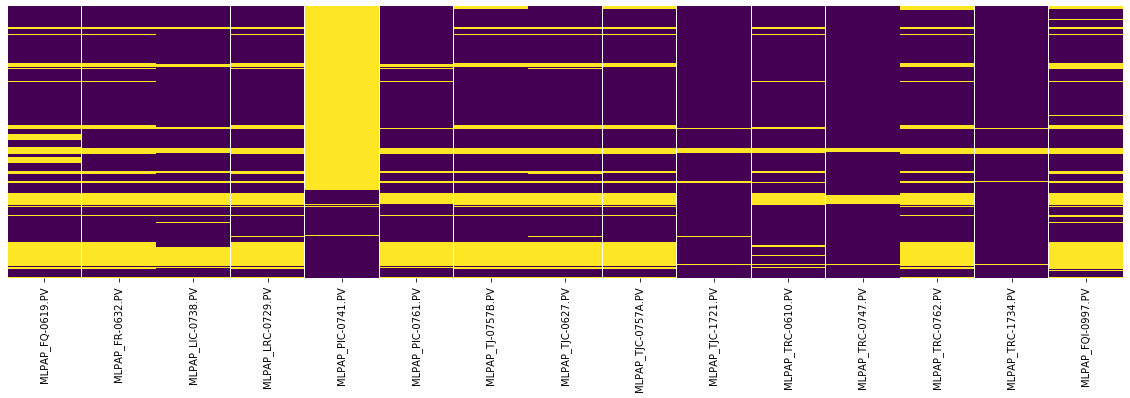

In [11]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# dropna(columns wise)

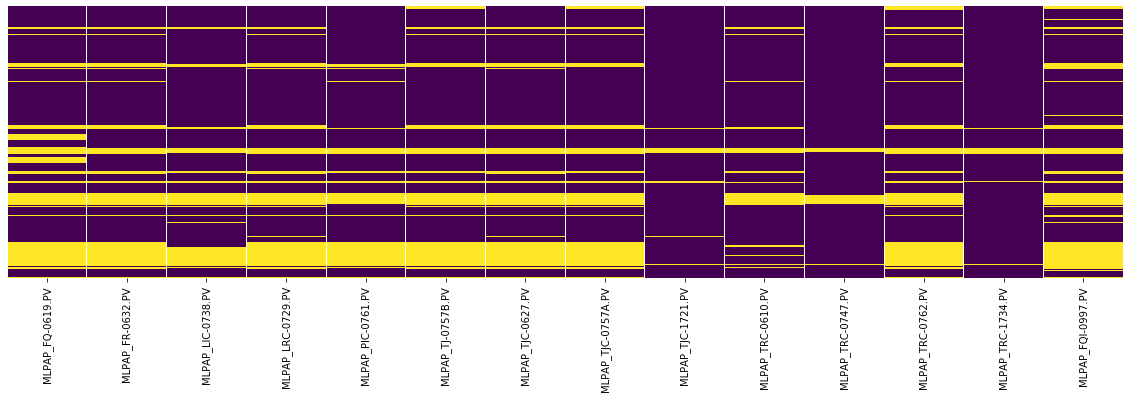

In [12]:
df = df.dropna(axis=1,thresh=len(df)*0.6)
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [13]:
control_factor = list(set(df.columns)&set(control_factor))
control_factor = sorted(control_factor)
control_factor

['MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [14]:
x_col = INPUT + control_factor
y_col = OUTPUT

# stack time_step

In [15]:
def train_windows(df, ref_day):
    X_train, Y_train, idx_lst = [], [], []
    for i in tqdm(range(len(df)-ref_day)):
        # 起始日 結束日
        start,end = i,i+ref_day
        
        # 確定該筆"instance"涵蓋的時間範圍內是否皆不含缺失值
        c = df.iloc[start:end+1].isnull().sum().sum()
        
        # 如果正常(不含缺失值)才製作成(X,y)pair
        if c == 0:
            X_train.append(df.iloc[start:end+1][x_col].values)
            Y_train.append(df.iloc[end][y_col].values[0])
            idx_lst.append(df.iloc[[end]].index[0])
        # 如果不正常就跳過
        else:
            pass
    
    # 重整資料 將二維X做flat 將y變Series
    X_train = np.array(X_train)
    flat_size = X_train.shape[1]*X_train.shape[2]
    X_train = X_train.reshape(-1,flat_size)
    Y_train = pd.Series(Y_train,index = idx_lst,name = 'Y')
    
    return X_train, Y_train, idx_lst

# make X,y pair need long time

In [16]:
s = time.time()
X,Y,idx_lst = train_windows(df,38)
Y = Y.values.reshape(-1,1)
print(time.time()-s)
print(X.shape)
print(Y.shape)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



237.4224202632904
(120912, 507)
(120912, 1)


# save X,y

In [17]:
dataset = {}

dataset['X'] = X
dataset['x_col'] = x_col

dataset['Y'] = Y
dataset['y_col'] = y_col

dataset['idx'] = idx_lst

dataset['c_col'] = control_factor

joblib.dump(dataset,'./data/train_preprocessed')
print('save done')

save done
